# SPT Data Processing

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

Este notebook se puede ejecutar interactivamente en [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/EAFIT_slope_stability/blob/main/notebooks/spt_processing.ipynb).


## Required modules and global setup for plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit, minimize
from ipywidgets import widgets as wgt
from IPython import get_ipython
from IPython.display import display

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    from subprocess import run
    run('pip install ipympl', shell=True);
    from google.colab import output, files
    output.enable_custom_widget_manager()
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename

# Figures setup
%matplotlib widget
plt.style.use("default")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "DejaVu Serif",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)

def display_fig(fig, static_fig=False):
    if static_fig and 'google.colab' in str(get_ipython()):
        display(fig)
    else:
        plt.show()
        display(wgt.HTML(  # To not display the window title
            '<style> div.jupyter-widgets.widget-label {display: none;} </style>'))
    plt.close()

## Funciones

In [2]:
def x_from_y(x_coord, y_coord, target_y):
    for i in range(len(y_coord)):
        if y_coord[i] == target_y:  # if target_y coincides with a node
            if i < len(y_coord) and y_coord[i+1] == y_coord[i]:  # if on a horizontal segment:
                return 0.5 * (x_coord[i] + x_coord[i+1])  # return midpoint in x
            else:
                return x_coord[i]
        elif i > 0 and y_coord[i-1] < target_y < y_coord[i]:
            # Interpolate x-value when the target y-value lies between two points
            x1, x2 = x_coord[i-1], x_coord[i]
            y1, y2 = y_coord[i-1], y_coord[i]
            return x1 + (x2 - x1) * (target_y - y1) / (y2 - y1)
    return None  # Return None if y-value not found within the range

def compute__stresses(df, mat_depths, 𝛾_moist, 𝛾_sat, wt_depth=None):
    𝛾_w = 9.81  # unit weight of water [kN/m³]
    # Copying arrays
    mat_depths = mat_depths.copy()
    𝛾_moist = 𝛾_moist.copy()
    𝛾_sat = 𝛾_sat.copy()
    # Find an appropiate index for locating the watertable
    if wt_depth in mat_depths:
        idx_wt = mat_depths.index(wt_depth)
    elif wt_depth >= mat_depths[-1] or wt_depth is None:
        wt_depth = mat_depths[-1]
        idx_wt = len(mat_depths) - 1
    else:
        for i in range(len(mat_depths)):
            if wt_depth <= mat_depths[i]:
                idx_wt = i
                break
    # Insert the new value at the appropriate index
    mat_depths.insert(idx_wt, wt_depth)
    𝛾_moist.insert(idx_wt, 𝛾_moist[idx_wt])
    𝛾_sat.insert(idx_wt, 𝛾_sat[idx_wt])
    # Create an unified unit weight vector
    𝛾_s = 𝛾_moist[: idx_wt + 1] + 𝛾_sat[idx_wt + 1 :]
    # Create vector of thicknesses
    mat_depths.insert(0, 0)  # insert zero for the first layer
    thickness = np.diff(mat_depths)  # thickness of each soil layer [m]
    # Create a vector for unit weigth of water (zero above wt, and 𝛾_w below)
    𝛾_w = np.full_like(𝛾_s, 𝛾_w)
    𝛾_w[: idx_wt + 1] = 0
    # Compute vertical stresses and water pressure at boundaries
    𝜎_v = np.insert(np.cumsum(thickness * 𝛾_s), 0, 0)
    p_w = np.insert(np.cumsum(thickness * 𝛾_w), 0, 0)
    𝜎_v_eff = 𝜎_v - p_w
    df['Sigma_eff_(kPa)'] = [
        x_from_y(x_coord=𝜎_v_eff, y_coord=mat_depths, target_y=z)
        for z in df['Profundidad_(m)'].to_numpy()
    ]
    return

def compute_corrected_N(df, perfo_diam, field_test_energy):
    # Stress level correction
    n, 𝜎_ref = 0.5, 95.76  # reference stress level = 1 tsf(short) to kPa
    # df['Cn'] = (𝜎_ref / df['Sigma_eff_(kPa)']) ** n  # Liao y Whitman (1986)
    df['Cn'] = 2 / (1 + df['Sigma_eff_(kPa)']/𝜎_ref)  # Skempton (1986)
    # Correction factor to reach an standard energy level of 60%
    df['n1_E60'] = field_test_energy / 60
    # Correction factor due to the length of the drill rod
    n2 = np.empty_like(df['Profundidad_(m)'])
    depth = df['Profundidad_(m)'].to_numpy()
    n2[depth >= 10] = 1
    n2[depth < 10] = 0.95
    n2[depth < 6] = 0.85
    n2[depth < 4] = 0.75
    df['n2'] = n2
    # Correction factor due to the cassing
    mat_type = np.array([int(d[0]) for d in df['Descripción'].to_list()])
    n3 = np.ones_like(df['Profundidad_(m)'])
    n3[mat_type == 1] = 0.8
    n3[mat_type == 2] = 0.8
    n3[mat_type == 3] = 0.9
    n3[mat_type == 4] = 0.8
    n3[mat_type == 5] = 0.85
    n3[mat_type == 6] = 0.9
    n3[df['Revestimiento_(m)'] < df['Profundidad_(m)']] = 1
    df['n3'] = n3
    # Correction factor due to the hole diameter
    if perfo_diam <= 120:
        df['n4'] = 1
    elif perfo_diam <= 150:
        df['n4'] = 1.05
    elif perfo_diam > 150:
        df['n4'] = 1.15
    # N corrected
    df['N45'] = np.int64(df['N_campo'] * df['Cn'] * df['n2'] * df['n3'] * df['n4'] * field_test_energy / 45)
    df['N55'] = np.int64(df['N_campo'] * df['Cn'] * df['n2'] * df['n3'] * df['n4'] * field_test_energy / 55)
    df['N60'] = np.int64(df['N_campo'] * df['Cn'] * df['n2'] * df['n3'] * df['n4'] * field_test_energy / 60)

def compute_correlations(df, corr_𝜙='f'):
    '''
    Correlations for the friction angle based on the letters accompanying the
    formulas (7) and (8) in Gonzalez (1999)
    '''
    # Equivalent friction angle
    if corr_𝜙 == 'a':  # Peck
        df['𝜙_eq'] = 28.5 + 0.25 * df['N45']
    elif corr_𝜙 == 'b':  # Peck, Hanson & Thornburn
        df['𝜙_eq'] = 26.25 * (2 - np.exp(-1 * df['N45']/62))
    elif corr_𝜙 == 'c':  # Kishida
        df['𝜙_eq'] = 15 + (12.5 * df['N45']) ** 0.5
    elif corr_𝜙 == 'd':  # Schmertmann
        df['𝜙_eq'] = np.arctan((df['N45'] / 43.3)**0.34)
    elif corr_𝜙 == 'e':  # Japan National Railway (JNR)
        df['𝜙_eq'] = 27 + 0.1875 * df['N45']
    elif corr_𝜙 == 'f':  # Japan Road Bureau (JRB)
        df['𝜙_eq'] = 15 + (9.375 * df['N45']) ** 0.5
    # Equivalent shear strength
    df['𝜏_eq'] = df['Sigma_eff_(kPa)'] * np.tan(np.deg2rad(df['𝜙_eq']))
    # Elasticity modulus
    mat_type = np.array([int(d[0]) for d in df['Descripción'].to_list()])
    elastic_mod = np.ones_like(df['Profundidad_(m)'])
    elastic_mod[mat_type == 1] = (250 * (df['N55'] + 15))[mat_type == 1]
    elastic_mod[mat_type == 2] = (500 * (df['N55'] + 15))[mat_type == 2]
    elastic_mod[mat_type == 3] = (40000 + (df['N55'] * 1050))[mat_type == 3]
    mask_4a = np.logical_and(mat_type == 4, df['N55'] <= 15)
    elastic_mod[mask_4a] = (600 * (df['N55'] + 6))[mask_4a]
    mask_4b = np.logical_and(mat_type == 4, df['N55'] > 15)
    elastic_mod[mask_4b] = (2000 + (600 * (df['N55'] + 6)))[mask_4b]
    elastic_mod[mat_type == 5] = (320 * (df['N55'] + 15))[mat_type == 5]
    elastic_mod[mat_type == 6] = (300 * (df['N55'] + 6))[mat_type == 6]
    df['Es_(kPa)'] = elastic_mod


def complete_table(df, mat_depths, 𝛾_moist, 𝛾_sat, wt_depth=None, perfo_diam=75,
                   field_test_energy=60, corr_𝜙='f'):
    compute__stresses(df, mat_depths, 𝛾_moist, 𝛾_sat, wt_depth)
    compute_corrected_N(df, perfo_diam, field_test_energy)
    compute_correlations(df, corr_𝜙='f')

def f(x, m, b):
    return m * x + b

def f_b0(x, m):
    return m * x

def plot_processing(df, mat_depths, wt_depth, figsize=[9, 6]):
    fig, axs = plt.subplot_mosaic([['A', 'B', 'B'], ['A', '.', '.']],
                              layout='constrained', figsize=figsize)
    for i, mat in enumerate(df['Material'].unique()):
        df_mat = df[df['Material'] == mat]
        # Plotting N values vs depth
        axs['A'].plot(df_mat['N_campo'], df_mat['Profundidad_(m)'], ls="", marker="o",
                      mfc="w", mec=f"C{i}")#, label=mat)
        # Plotting shear strength vs sigma_v
        axs['B'].plot(df_mat['Sigma_eff_(kPa)'], df_mat['𝜏_eq'], ls="", marker="o",
                      mfc="w", mec=f"C{i}", label=mat)
        m, b = curve_fit(f, df_mat['Sigma_eff_(kPa)'], df_mat['𝜏_eq'])[0]
        if b < 0:
            m, b = curve_fit(f_b0, df_mat['Sigma_eff_(kPa)'], df_mat['𝜏_eq'])[0][0], 0.0
        phi = np.rad2deg(m)
        axs['B'].plot(df_mat['Sigma_eff_(kPa)'], m * df_mat['Sigma_eff_(kPa)'] + b,
                      ls='--', c=f"C{i}", label=f"$\\phi'={phi:.1f}^\\circ$, $c'={b:.1f}$ kPa")

    for d in mat_depths:
        axs['A'].axhline(d, color="k", ls="--", lw=1.5)
    axs['A'].axhline(0, color="k", ls="-", lw=1.5, label="Terrain surface")
    axs['A'].axhline(0, color="k", ls="--", lw=1.5, label="Material boundary")
    axs['A'].axhline(y=wt_depth, ls="-", color="b", lw=1.2, label="Watertable")

    # Plot setup
    axs['A'].invert_yaxis()
    axs['A'].set(xlabel="N$_\\mathrm{SPT}$", ylabel="Depth [m]", xlim=[-5, 105])
    axs['B'].set(xlabel="$\\sigma'$  [kPa]", ylabel="$\\tau'$  [kPa]")
    for ax in axs.values():
        ax.xaxis.set_label_position("top")
        ax.xaxis.tick_top()
        ax.spines["top"].set_linewidth(1.5)
        ax.spines["left"].set_linewidth(1.5)
        ax.grid(True, ls="--", color="silver")
    fig.legend(loc='upper center', bbox_to_anchor=(0.7, 0.45), ncol=1)
    display_fig(fig)
    return fig


## Ejemplo 1

### Reading the input data

In [3]:
mat_depths = [7, 14]  # bottom depth of each material [m]
𝛾_moist = [18.50, 16.00]  # Total/moist/bulk unit weight of each soil layer [kN/m³]
𝛾_sat = [19.50, 17.50]  # Saturated unit weight of each soil layer [kN/m³]
wt_depth = 10  # watertable depth [m]
perfo_diam = 75  # [mm]
field_test_energy = 45  # [%]
corr_𝜙 = 'f'  # JRB

# Loading tabulated field test data
if 'google.colab' in str(get_ipython()):
    file = files.upload()
    df = pd.read_excel(list(file.values())[0])
else:
    tk.Tk().withdraw() # part of the import if you are not using other tkinter functions
    file = askopenfilename()
    df = pd.read_excel(file)
df

/home/eamontoyaa/.pyenv/versions/3.9.17/envs/EAFIT-env/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,Material,Descripción,Profundidad_(m),Revestimiento_(m),N_campo
0,Dep. Antrópico,4 - Arena con contenido de gravas,0.3,0,33
1,Dep. Antrópico,4 - Arena con contenido de gravas,1.3,0,18
2,Dep. Antrópico,4 - Arena con contenido de gravas,2.3,0,12
3,Dep. Antrópico,4 - Arena con contenido de gravas,3.3,0,10
4,Dep. Antrópico,4 - Arena con contenido de gravas,4.3,0,13
5,Dep. Antrópico,4 - Arena con contenido de gravas,5.3,0,11
6,Dep. Antrópico,4 - Arena con contenido de gravas,6.3,0,16
7,Ceniza Volc.,5 - Arena limosa y/o arcillosa,7.3,2,21
8,Ceniza Volc.,5 - Arena limosa y/o arcillosa,8.3,2,15
9,Ceniza Volc.,5 - Arena limosa y/o arcillosa,9.3,2,28


### Processing the data and completing the table

In [4]:
complete_table(df, mat_depths, 𝛾_moist, 𝛾_sat, wt_depth, perfo_diam, field_test_energy, corr_𝜙)
df

,Material,Descripción,Profundidad_(m),Revestimiento_(m),N_campo,Sigma_eff_(kPa),Cn,n1_E60,n2,n3,n4,N45,N55,N60,𝜙_eq,𝜏_eq,Es_(kPa)
0,Dep. Antrópico,4 - Arena con contenido de gravas,0.3,0,33,5.550,1.890435,0.75,0.75,1.0,1,46,38,35,35.766560,3.997864,28400.0
1,Dep. Antrópico,4 - Arena con contenido de gravas,1.3,0,18,24.050,1.598531,0.75,0.75,1.0,1,21,17,16,29.031215,13.348266,15800.0
2,Dep. Antrópico,4 - Arena con contenido de gravas,2.3,0,12,42.550,1.384715,0.75,0.75,1.0,1,12,10,9,25.606602,20.392573,9600.0
3,Dep. Antrópico,4 - Arena con contenido de gravas,3.3,0,10,61.050,1.221351,0.75,0.75,1.0,1,9,7,6,24.185587,27.418500,7800.0
4,Dep. Antrópico,4 - Arena con contenido de gravas,4.3,0,13,79.550,1.092465,0.75,0.85,1.0,1,12,9,9,25.606602,38.125244,9000.0
5,Dep. Antrópico,4 - Arena con contenido de gravas,5.3,0,11,98.050,0.988184,0.75,0.85,1.0,1,9,7,6,24.185587,44.035773,7800.0
6,Dep. Antrópico,4 - Arena con contenido de gravas,6.3,0,16,116.550,0.902077,0.75,0.95,1.0,1,13,11,10,26.039701,56.945237,10200.0
7,Ceniza Volc.,5 - Arena limosa y/o arcillosa,7.3,2,21,134.300,0.832478,0.75,0.95,1.0,1,16,13,12,27.247449,69.161479,8960.0
8,Ceniza Volc.,5 - Arena limosa y/o arcillosa,8.3,2,15,150.300,0.778347,0.75,0.95,1.0,1,11,9,8,25.155048,70.581834,7680.0
9,Ceniza Volc.,5 - Arena limosa y/o arcillosa,9.3,2,28,166.300,0.730825,0.75,0.95,1.0,1,19,15,14,28.346348,89.716925,9600.0


## Plotting the processed data

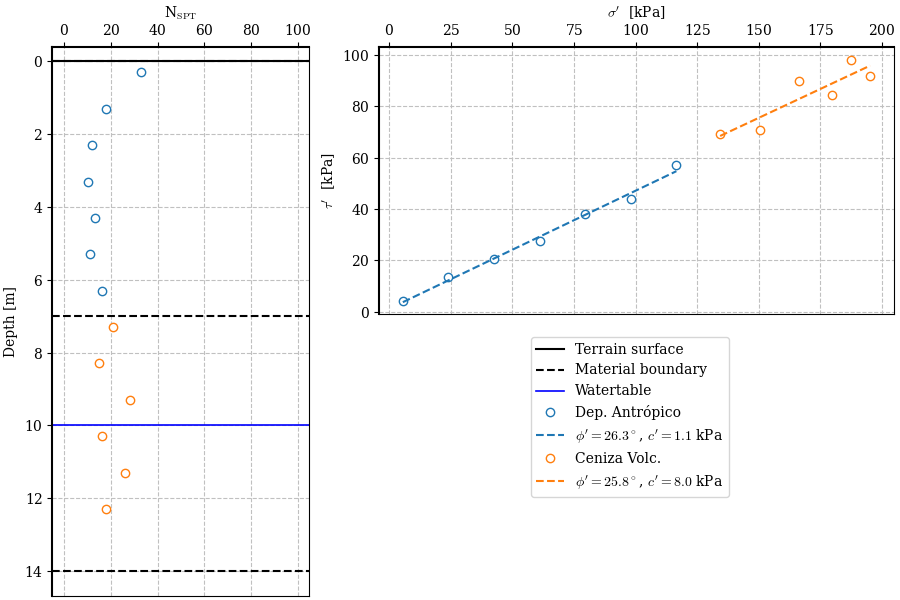

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

In [5]:
fig = plot_processing(df, mat_depths, wt_depth)

## Ejemplo 2

### Reading the input data

In [6]:
# Input data
mat_depths = [5.5, 13, 18]  # bottom depth of each material [m]
𝛾_moist = [17.00, 18.30, 18.50]  # Total/moist/bulk unit weight of each soil layer [kN/m³]
𝛾_sat = [18.00, 19.30, 19.50]  # Saturated unit weight of each soil layer [kN/m³]
wt_depth = 7  # watertable depth [m]
perfo_diam = 75  # [mm]
field_test_energy = 45  # [%]

# Loading tabulated field test data
if 'google.colab' in str(get_ipython()):
    file = files.upload()
    df_2 = pd.read_excel(list(file.values())[0])
else:
    tk.Tk().withdraw() # part of the import if you are not using other tkinter functions
    file = askopenfilename()
    df_2 = pd.read_excel(file)
df_2

/home/eamontoyaa/.pyenv/versions/3.9.17/envs/EAFIT-env/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,Material,Descripción,Profundidad_(m),Revestimiento_(m),N_campo
0,Dep. de vertiente,"6 - Limos, suelos finogranulares",0.25,0,4
1,Dep. de vertiente,"6 - Limos, suelos finogranulares",1.25,0,12
2,Dep. de vertiente,"6 - Limos, suelos finogranulares",2.25,0,11
3,Dep. de vertiente,"6 - Limos, suelos finogranulares",4.25,0,9
4,Dep. de vertiente,"6 - Limos, suelos finogranulares",5.25,0,12
5,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,7.25,6,12
6,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,8.25,6,23
7,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,10.25,6,19
8,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,11.25,6,16
9,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,12.25,6,33


### Processing the data and completing the table

In [7]:
complete_table(df_2, mat_depths, 𝛾_moist, 𝛾_sat, wt_depth, perfo_diam, field_test_energy, corr_𝜙)
df_2

,Material,Descripción,Profundidad_(m),Revestimiento_(m),N_campo,Sigma_eff_(kPa),Cn,n1_E60,n2,n3,n4,N45,N55,N60,𝜙_eq,𝜏_eq,Es_(kPa)
0,Dep. de vertiente,"6 - Limos, suelos finogranulares",0.25,0,4,4.2500,1.915008,0.75,0.75,1.0,1,5,4,4,21.846532,1.703884,3000.0
1,Dep. de vertiente,"6 - Limos, suelos finogranulares",1.25,0,12,21.2500,1.636783,0.75,0.75,1.0,1,14,12,11,26.456439,10.574695,5400.0
2,Dep. de vertiente,"6 - Limos, suelos finogranulares",2.25,0,11,38.2500,1.429147,0.75,0.75,1.0,1,11,9,8,25.155048,17.962443,4500.0
3,Dep. de vertiente,"6 - Limos, suelos finogranulares",4.25,0,9,72.2500,1.139932,0.75,0.85,1.0,1,8,7,6,23.660254,31.655773,3900.0
4,Dep. de vertiente,"6 - Limos, suelos finogranulares",5.25,0,12,89.2500,1.035187,0.75,0.85,1.0,1,10,8,7,24.682458,41.017313,4200.0
5,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,7.25,6,12,123.3225,0.874191,0.75,0.95,1.0,1,9,8,7,24.185587,55.386044,7360.0
6,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,8.25,6,23,132.8125,0.837896,0.75,0.95,1.0,1,18,14,13,27.990381,70.589061,9280.0
7,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,10.25,6,19,151.7925,0.773654,0.75,1.00,1.0,1,14,12,11,26.456439,75.536911,8640.0
8,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,11.25,6,16,161.2825,0.745091,0.75,1.00,1.0,1,11,9,8,25.155048,75.739286,7680.0
9,Horizonte IC - Migmatita - Sup,5 - Arena limosa y/o arcillosa,12.25,6,33,170.7725,0.718562,0.75,1.00,1.0,1,23,19,17,29.684175,97.344412,10880.0


### Plotting the processed data

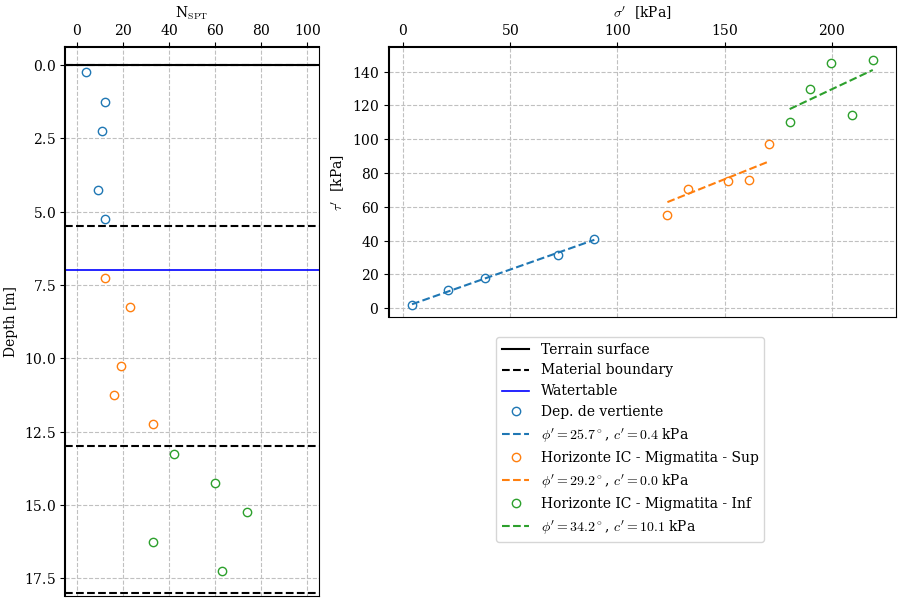

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

In [8]:
fig = plot_processing(df_2, mat_depths, wt_depth)